## POS tagging using modified Viterbi

### Data Preparation

In [20]:
#Importing libraries
import nltk

In [21]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [22]:
# Other libraries for processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.filterwarnings('ignore')

## Understanding Data

In [23]:
# Let's feel data how it is
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [24]:
len(nltk_data)

3914

#### Random Seed: (For understanding)
Seeding a pseudo-random number generator gives it its first "previous" value. Each seed value will correspond to a sequence of generated values for a given random number generator. That is, `if you provide the same seed twice, you get the same sequence of numbers twice`.

In [25]:
# Splitting into train and validation set
random.seed(1234)
# Splitting in validation set as per 
train_set, val_set = train_test_split(nltk_data,test_size=0.05)
# Varification
print(len(train_set))
print(len(val_set))
print(train_set[:5])

3718
196
[[('Mr.', 'NOUN'), ('Hahn', 'NOUN'), (',', '.'), ('the', 'DET'), ('62-year-old', 'ADJ'), ('chairman', 'NOUN'), ('and', 'CONJ'), ('chief', 'NOUN'), ('executive', 'ADJ'), ('officer', 'NOUN'), ('of', 'ADP'), ('Georgia-Pacific', 'NOUN'), ('Corp.', 'NOUN'), ('is', 'VERB'), ('leading', 'VERB'), ('the', 'DET'), ('forest-product', 'NOUN'), ('concern', 'NOUN'), ("'s", 'PRT'), ('unsolicited', 'ADJ'), ('$', '.'), ('3.19', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('bid', 'NOUN'), ('for', 'ADP'), ('Great', 'NOUN'), ('Northern', 'NOUN'), ('Nekoosa', 'NOUN'), ('Corp', 'NOUN'), ('.', '.')], [('Profit', 'NOUN'), ('surged', 'VERB'), ('42', 'NUM'), ('%', 'NOUN'), ('to', 'PRT'), ('40.21', 'NUM'), ('billion', 'NUM'), ('yen', 'NOUN'), (',', '.'), ('or', 'CONJ'), ('16.09', 'NUM'), ('yen', 'NOUN'), ('a', 'DET'), ('share', 'NOUN'), (',', '.'), ('from', 'ADP'), ('28.36', 'NUM'), ('billion', 'NUM'), ('yen', 'NOUN'), (',', '.'), ('or', 'CONJ'), ('11.72', 'NUM'), ('yen', 'NOUN'), ('a', 'DET'), ('share', 

In [26]:
# Getting list of tagged words
train_tagged_words=[tup for sent in train_set for tup in sent]
print(len(train_tagged_words))
print(train_tagged_words[:5])

95533
[('Mr.', 'NOUN'), ('Hahn', 'NOUN'), (',', '.'), ('the', 'DET'), ('62-year-old', 'ADJ')]


In [27]:
# Tokenizing the data set
tokens=[pair[0] for pair in train_tagged_words]
print(len(tokens))
print(tokens[:5])

95533
['Mr.', 'Hahn', ',', 'the', '62-year-old']


In [28]:
# Vocab by using set function which gives unique words
vocab = set(tokens)
print(len(vocab))

12084


### Data
As per data defination in assignment, the Treebank dataset of NLTK with the 'universal' tagset. The Universal tagset of NLTK comprises only `12 coarse tag` classes as follows: `Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.` which we got below

In [29]:
# Tags set to get unique words
tags=set([pair[1] for pair in train_tagged_words])
len(tags)

12

In [30]:
print(tags)

{'NUM', '.', 'NOUN', 'DET', 'ADP', 'PRON', 'ADJ', 'VERB', 'PRT', 'X', 'CONJ', 'ADV'}


#### Emission Probabilities
Computing `P(w/t)` and storing in `tag x vocab` matrix

In [31]:
# Creating null matrix for `P(w/t)
t = len(tags)
v=len(vocab)
w_given_t = np.zeros((t,v))

In [32]:
# Compute word given tag (Emission probability)
def word_given_tag(word,tag,train_bag=train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag=len(tag_list)
    w_given_tag_list=[pair[0] for pair in tag_list if pair[0]==word ]
    count_w_given_tag=len(w_given_tag_list)
    
    return (count_w_given_tag,count_tag)
    

#### Transition Probability

In [33]:
def t2_given_t1(t,t1,train_bag=train_tagged_words):
    tags=[pair[1] for pair in train_bag]
    count_t1=len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 +=1
    return(count_t2_t1, count_t1)

In [35]:
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [36]:
tags_matrix

array([[1.82494789e-01, 1.17594525e-01, 3.55462939e-01, 2.67936895e-03,
        3.51295024e-02, 1.48853823e-03, 3.36409658e-02, 1.78624596e-02,
        2.73891035e-02, 2.09586188e-01, 1.36945518e-02, 2.97707645e-03],
       [8.05000886e-02, 9.37218890e-02, 2.23241597e-01, 1.74311921e-01,
        9.09336209e-02, 6.59291223e-02, 4.30832878e-02, 8.88649002e-02,
        2.24860595e-03, 2.74329912e-02, 5.72045334e-02, 5.24374880e-02],
       [9.33931675e-03, 2.40742773e-01, 2.64638275e-01, 1.32793402e-02,
        1.75914779e-01, 4.77910321e-03, 1.22943344e-02, 1.46364599e-01,
        4.37415652e-02, 2.90394370e-02, 4.27565575e-02, 1.71099193e-02],
       [2.19224282e-02, 1.71043128e-02, 6.39966249e-01, 5.05902199e-03,
        9.39532649e-03, 3.73404007e-03, 2.04649478e-01, 3.96290049e-02,
        2.40905807e-04, 4.55311984e-02, 3.61358718e-04, 1.24066491e-02],
       [6.35993108e-02, 3.94680388e-02, 3.20463330e-01, 3.25504065e-01,
        1.67310163e-02, 7.00343177e-02, 1.05426855e-01, 8.25

In [39]:
tags_df=pd.DataFrame(tags_matrix,columns=list(tags),index=list(tags))
tags_df.head()

,NUM,.,NOUN,DET,ADP,PRON,ADJ,VERB,PRT,X,CONJ,ADV
NUM,0.182495,0.117595,0.355463,0.002679,0.035130,0.001489,0.033641,0.017862,0.027389,0.209586,0.013695,0.002977
.,0.080500,0.093722,0.223242,0.174312,0.090934,0.065929,0.043083,0.088865,0.002249,0.027433,0.057205,0.052437
NOUN,0.009339,0.240743,0.264638,0.013279,0.175915,0.004779,0.012294,0.146365,0.043742,0.029039,0.042757,0.017110
DET,0.021922,0.017104,0.639966,0.005059,0.009395,0.003734,0.204649,0.039629,0.000241,0.045531,0.000361,0.012407
ADP,0.063599,0.039468,0.320463,0.325504,0.016731,0.070034,0.105427,0.008258,0.001394,0.034856,0.000858,0.013406


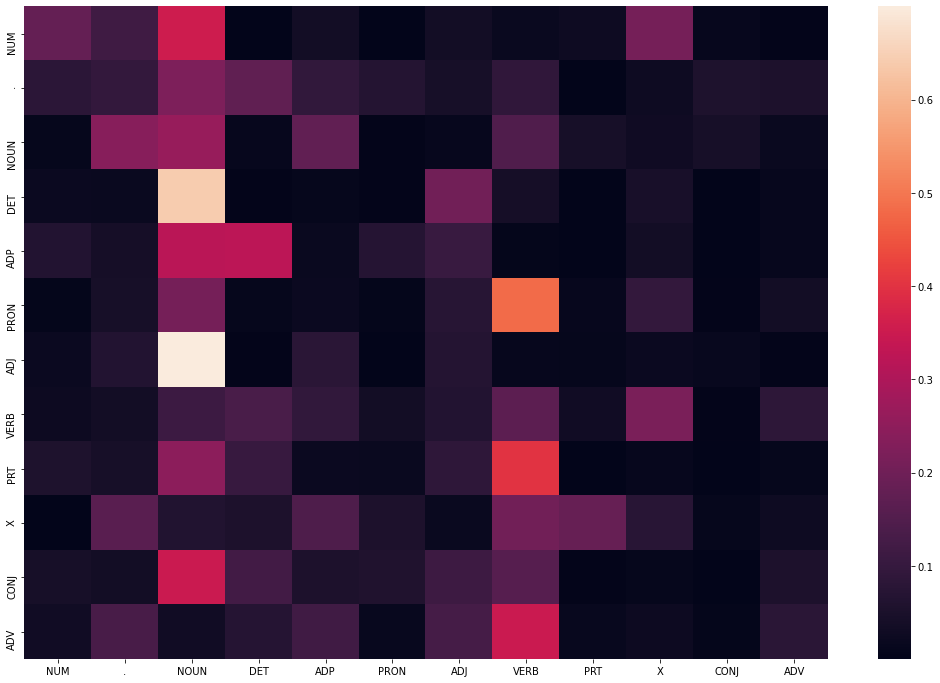

In [40]:
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

<AxesSubplot:>

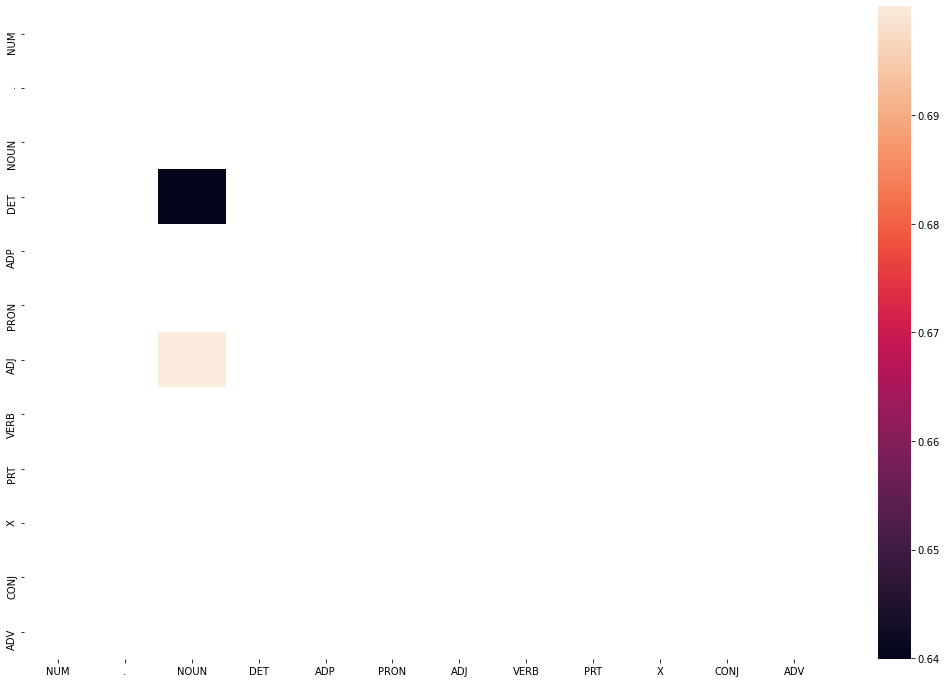

In [41]:
tags_frequent=tags_df[tags_df>0.5]
plt.figure(figsize=(18,12))
sns.heatmap(tags_frequent)

### Build the vanilla Viterbi based POS tagger

In [43]:
len(train_tagged_words)

95533

In [54]:
# Viterbi Based POS tagger

def Viterbi(words,train_bag=train_tagged_words):
    state=[]
    T=list(set([pair[1] for pair in train_bag]))
    for key,word in enumerate(words):
        p=[]
        if key==0:
            transition_p=tags_df.loc['.',tags]
        else:
            transition_p = tags_df.loc[state[-1],tags]
            
            #emission prob                   
            emission_p = word_given_tag(word[key],tag)[0]/word_given_tag(word[key],tag)[1]
            # state prob
            state_p=emission_p*transition_p
            p.append(state_p)
            
            pmax=max(p)
            # max prob state
            state_max=tags[p.index(pmax)]
            state.append(state_max)
        return list(zip(word,state))
            

In [52]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(val_set)) for x in range(5)]

# list of sents
val_run = [val_set[i] for i in rndom]

# list of tagged words
val_run_base = [tup for sent in val_run for tup in sent]

# list of untagged words
val_tagged_words = [tup[0] for sent in val_run for tup in sent]
val_run

[[('But', 'CONJ'),
  ('with', 'ADP'),
  ('the', 'DET'),
  ('end', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('year', 'NOUN'),
  ('in', 'ADP'),
  ('sight', 'NOUN'),
  (',', '.'),
  ('money', 'NOUN'),
  ('managers', 'NOUN'),
  ('are', 'VERB'),
  ('eager', 'ADJ'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('take', 'VERB'),
  ('profits', 'NOUN'),
  ('and', 'CONJ'),
  ('cut', 'VERB'),
  ('their', 'PRON'),
  ('risks', 'NOUN'),
  ('of', 'ADP'),
  ('*-2', 'X'),
  ('losing', 'VERB'),
  ('what', 'PRON'),
  ('for', 'ADP'),
  ('many', 'ADJ'),
  ('*T*-178', 'X'),
  ('have', 'VERB'),
  ('been', 'VERB'),
  ('exceptionally', 'ADV'),
  ('good', 'ADJ'),
  ('returns', 'NOUN'),
  ('in', 'ADP')],
 [('With', 'ADP'),
  ('the', 'DET'),
  ('shudders', 'NOUN'),
  ('came', 'VERB'),
  ('*T*-2', 'X'),
  ('the', 'DET'),
  ('realization', 'NOUN'),
  ('that', 'ADP'),
  ('some', 'DET'),
  ('of', 'ADP'),
  ('Wall', 'NOUN'),
  ('Street', 'NOUN'),
  ("'s", 'PRT'),
  ('biggest', 'ADJ'),
  ('players', 'NOUN'),
  ('are', 'VERB

In [55]:
tagged_seq = Viterbi(val_tagged_words)

In [56]:
print(tagged_seq,val_run_base)

[] [('But', 'CONJ'), ('with', 'ADP'), ('the', 'DET'), ('end', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('year', 'NOUN'), ('in', 'ADP'), ('sight', 'NOUN'), (',', '.'), ('money', 'NOUN'), ('managers', 'NOUN'), ('are', 'VERB'), ('eager', 'ADJ'), ('*-1', 'X'), ('to', 'PRT'), ('take', 'VERB'), ('profits', 'NOUN'), ('and', 'CONJ'), ('cut', 'VERB'), ('their', 'PRON'), ('risks', 'NOUN'), ('of', 'ADP'), ('*-2', 'X'), ('losing', 'VERB'), ('what', 'PRON'), ('for', 'ADP'), ('many', 'ADJ'), ('*T*-178', 'X'), ('have', 'VERB'), ('been', 'VERB'), ('exceptionally', 'ADV'), ('good', 'ADJ'), ('returns', 'NOUN'), ('in', 'ADP'), ('With', 'ADP'), ('the', 'DET'), ('shudders', 'NOUN'), ('came', 'VERB'), ('*T*-2', 'X'), ('the', 'DET'), ('realization', 'NOUN'), ('that', 'ADP'), ('some', 'DET'), ('of', 'ADP'), ('Wall', 'NOUN'), ('Street', 'NOUN'), ("'s", 'PRT'), ('biggest', 'ADJ'), ('players', 'NOUN'), ('are', 'VERB'), ('struggling', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('maintain', 'VERB'), ('the', 'DET'), ('st

### Solve the problem of unknown words

#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications